<a href="https://colab.research.google.com/github/behroozmrd47/Indian_Food_Analysis/blob/develop/Indian_food_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indian_Food_Analysis

##Intro
The goal of this notebook is to analyze the [Indian Food Dataset](https://www.kaggle.com/nehaprabhavalkar/indian-food-101) avaialble on Kaggle. below is a list of objectives to be done here:

* Visualize and analysis data
* Create filtering functions
* Create ML-based function for detecting similar foods
* Create ML-based recommendation function for recommending Gluten-free Food

##Table of Contents
* Data Exploration & Visualization
* Filter Function
* Recommending Similar Dishes
* Recommendation System for Gluten Free Dishes


In [238]:
#Import necesary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from IPython.display import display

## Data Exploration & Visualization
Data can be found on [Kaggle Indian Food Dataset](https://www.kaggle.com/nehaprabhavalkar/indian-food-101). The Indian Food Dataset has information regarding 255 Indian dishes with 9 fields: 'name', 'ingredients', 'diet', 'prep_time', 'cook_time', 'flavor_profile', 'course', 'state' and 'region'. A couple of typos e.g. "yoghurt" that was encountered while working with data is fixed.

In [239]:
data = pd.read_csv('indian_food.csv', header=0)
print('Dataset size is %s' % str(data.shape))
print('Dataset columns are %s' % list(data.columns))

# Lower casing all values and handling typos
for col_name in ['name', 'ingredients', 'diet', 'flavor_profile', 'course', 'state', 'region']:
    data[col_name] = data[col_name].str.lower()
data['ingredients'] = data['ingredients'].str.replace('chilli', 'chili')
data['ingredients'] = data['ingredients'].str.replace('yoghurt', 'yogurt')
display(data.head())


Dataset size is (255, 9)
Dataset columns are ['name', 'ingredients', 'diet', 'prep_time', 'cook_time', 'flavor_profile', 'course', 'state', 'region']


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,balu shahi,"maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,west bengal,east
1,boondi,"gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,rajasthan,west
2,gajar ka halwa,"carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,punjab,north
3,ghevar,"flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,rajasthan,west
4,gulab jamun,"milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,west bengal,east


Dataset has missing values marked with "-1" for five fields of 'prep_time', 'cook_time', 'flavor_profile', 'state', 'region' which are replaced by "np.nan".

To better understands the dataset, a set charts are generated exploring and visualizing the datset. Pie chart for vegeterian vs non-vegeterian dishes is shown below. It can be seen that almost 90% of dishes are from a vegeterian diet. The charts are generated including dishes with missing data and proportions of nan values for each field can be seen in charts below.

In [240]:
# Replacing -1 values with nan
data[(data == -1) | (data == '-1')] = np.nan
print('Columns %s has missing (NA) values.' %list(data.columns[data.isna().any()]))
data_print = data.apply(lambda x: x.astype(str).str.title())

def plot_pie_chart(dataframe, col_name, plot_title=None):
    col_count = dataframe[col_name].value_counts().reset_index()
    plt.pie(col_count[col_name], labels=col_count['index'], radius=1.2, autopct='%0.1f%%', explode=[0.1] * len(col_count['index']))
    if plot_title is not None:
      plt.title(plot_title)
    plt.show()

Columns ['prep_time', 'cook_time', 'flavor_profile', 'state', 'region'] has missing (NA) values.


To better understands and explore the dataset, a set of charts are generated. Proportions of various regions, courses and flavours are shown in pie charts below. It can be seen that:

* Almost 90% of dishes are from a vegetarian diet.
* A third of dishes come from west region of India.
* Half of available dishes are main courses.
* Half of available dishes are spicy".

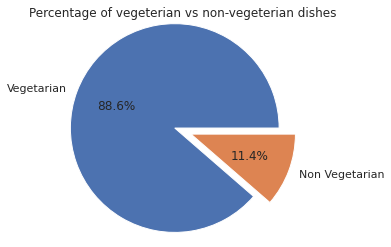

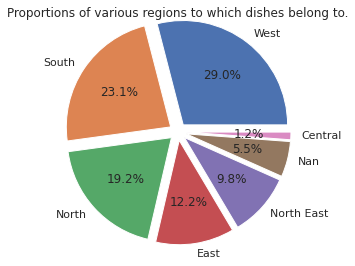

In [241]:
plot_pie_chart(dataframe = data_print,col_name = 'diet', plot_title = "Percentage of vegeterian vs non-vegeterian dishes")
plot_pie_chart(data_print,'region', plot_title='Proportions of various regions to which dishes belong to.')

Proportions of various courses.


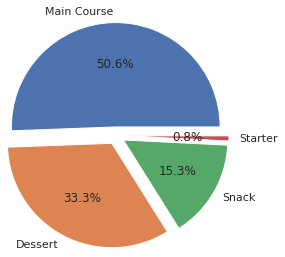


Proportions of various food flavors.


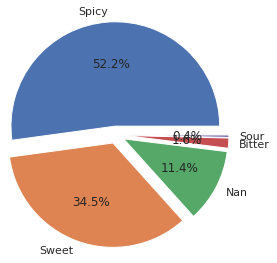

In [242]:
print('Proportions of various courses.')
plot_pie_chart(data_print,'course')
print('\nProportions of various food flavors.')
plot_pie_chart(data_print,'flavor_profile')

Total cooking time is defined as prep time + cooking time. The histogram of total cooking time  is shown below.

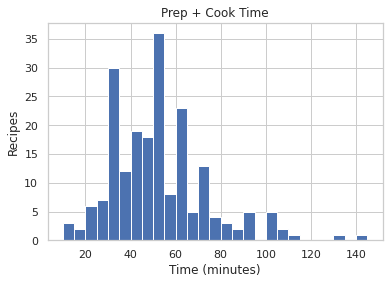

In [243]:
plt.hist(data['prep_time'] + data['cook_time'],np.arange(10,150,5))

plt.title('Prep + Cook Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Recipes')
plt.show()

Since fields with missing valus are used for filtering and recommendation methods, the missing values are addressed firstly.Dishes with missing values are not removed. Various methods could be used for replacing the missing values e.g. using means/modes or clustering dishes together. Exploring the data below observations are made regarding missing values:

* Fields of low importance have missing values e.g. state, region
* Share of missing values in each field are not considerable (max 10%) 
* The fields with missing values are not primary factors for our fucntions

Considering above, in case of numeric fields ('prep_time', 'cook_time') and  categorical fields ('flavor_profile', 'state', 'region') missing values are replaced by means and modes of their fields, respectively. 

**For presentation purposes, the values of missing values replaced by means/modes are shown followed by an asterick.**

In [244]:
# Handling nan values
data_print = data.copy()
# display(data_print.tail())
print('Mean of prep and cook time: \n' + str(data.mean().round()))
data_2 = data.fillna(data.mean().round())
for column in data_2.columns:
    data_2[column].fillna(data[column].mode()[0], inplace=True)

# Creating the dataframe for printing purposes. Replaced missing values shown with an asterick 
data_print = data_print.fillna(data_2.astype(str) + '*')
data_print = data_print.apply(lambda x: x.astype(str).str.title())
display(data_print.tail())

Mean of prep and cook time: 
prep_time    35.0
cook_time    39.0
dtype: float64


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
250,Til Pitha,"Glutinous Rice, Black Sesame Seeds, Gur",Vegetarian,5.0,30.0,Sweet,Dessert,Assam,North East
251,Bebinca,"Coconut Milk, Egg Yolks, Clarified Butter, All...",Vegetarian,20.0,60.0,Sweet,Dessert,Goa,West
252,Shufta,"Cottage Cheese, Dry Dates, Dried Rose Petals, ...",Vegetarian,35.0*,39.0*,Sweet,Dessert,Jammu & Kashmir,North
253,Mawa Bati,"Milk Powder, Dry Fruits, Arrowroot Powder, All...",Vegetarian,20.0,45.0,Sweet,Dessert,Madhya Pradesh,Central
254,Pinaca,"Brown Rice, Fennel Seeds, Grated Coconut, Blac...",Vegetarian,35.0*,39.0*,Sweet,Dessert,Goa,West


##Filter Function

This function filters the indian food dataset based on five criterias: ingredients, diet, course, max_prep_time, max_cook_time. At fist all input are checked to be of the right format and within the acceptable values. This process is not 100% error proof but can prevent elementary input errors. Then, if a valid input is passed for each criterion, the dish dataframe is filter based on. The 'ingredients' criteria are can be passed as a string or list of strings. It can be a single string or list/tuple of strings. The dataframe will be filtered for all ingredients in the ingredients list. Parameters are not case sensitive.

* param ingredients: The string of one ingredient or list/tuple of strings of multiple ingredients.
* param diet: The diet to be 'vegetarian' or 'non vegetarian'
* param course: The course for which the dish should be served can be 'dessert', 'main course', 'starter', 'snack'
* param max_prep_time: The maximum preparation rime
* param max_cook_time: The maximum cooking time

---
Below examples are all correct application of function: <br>
* filter_func (ingredients='oil', max_prep_time=100, max_cook_time=100, diet='non vegetarian') <br>
* filter_func(ingredients=['oil', 'rice'], max_prep_time=100, max_cook_time=100, diet='vegetarian', course='snack') <br>
* filter_func(ingredients='brown rice')

In [264]:
def filter_func(ingredients=None, diet=None, course=None, max_prep_time=None, max_cook_time=None):
    """
    Filter the indian food dataset based on 4 criteria: ingredients, diet, course, max_prep_time, max_cook_time.
    At fist all input are checked to be of the right format and within the acceptable values. This process is not
    100% error proof but can prevent elementary input errors. Then, if a valid input is passed for each criteria, the
    dish dataframe is filter based on. The 'ingredients' criteria is can be passed as a string or list of strings.
    It can be a single string or list/tuple of strings. The dataframe will be filtered for all ingredients in the
    passed ingredients list. Below examples are all correct application of function.
    filter_func(ingredients='oil', max_prep_time=100, max_cook_time=100, diet='non vegetarian')
    filter_func(ingredients=['oil', 'rice'], max_prep_time=100, max_cook_time=100, diet='vegetarian', course='snack')
    filter_func(ingredients='brown rice')

    :param ingredients: The string of one ingredient or list/tuple of strings of multiple ingredients.
    :param diet: The diet to be 'vegetarian' or 'non vegetarian'
    :param course: The course for which the dish should be served can be 'dessert', 'main course', 'starter', 'snack'
    :param max_prep_time: The maximum preparation rime
    :param max_cook_time: The maximum cooking time
    """
    global data_2
    data_term = data_2.copy()
    data_term['ingredients'] = data_term['ingredients'].apply(lambda x: [w.strip() for w in x.split(',')])

    # Filtering based on diet
    if diet is not None:
        diet = diet.lower()
        if diet not in data_2['diet'].unique():
            print('Diet input "%s" not valid. You may choose from: %s' % (diet, data_2['diet'].unique()))
            return
        else:
            print('Filtering dishes based on diet to be %s.' % diet)
            data_term = data_term[data_term['diet'] == diet]

    # Filtering based on course
    if course is not None:
        course = course.lower()
        if course not in data_2['course'].unique():
            print('Course input "%s" not valid. You may choose from: %s' % (course, data_2['course'].unique()))
            return
        else:
            print('Filtering dishes based on course type to be %s.' % course)
            data_term = data_term[data_term['course'] == course]

    # Filtering based on max prep time
    if max_prep_time is not None:
        try:
            max_prep_time = int(max_prep_time)
            print('Filtering dishes with max prep time of %d.' % max_prep_time)
            data_term = data_term[(data_term['prep_time'] <= max_prep_time)]
        except ValueError:
            print('Incorrect input for prep time (%s)' % max_prep_time)
            return

    # Filtering based on maximum cooking time
    if max_cook_time is not None:
        try:
            max_cook_time = int(max_cook_time)
            print('Filtering dishes with max cook time of %d.' % max_cook_time)
            data_term = data_term[(data_term['cook_time'] <= max_cook_time)]
        except ValueError:
            print('Incorrect input for cook time (%s)' % max_cook_time)
            return
    print('_'*80)

    if ingredients is None:
        print('There are %d dishes which met above criteria/s.' % len(data_term))
        display(data_2.loc[data_term.index].head())
        return
    if type(ingredients) is str:
        if ingredients.strip() == '':
            print('There are %d dishes which met above criteria/s.' % len(data_term))
            display(data_2.loc[data_term.index].head())
            return
        ingred_list = [ingredients.lower().strip()]
    else:
        ingred_list = [x.lower().strip() for x in ingredients]

    data_word = data_term.copy()
    data_word['ingredients'] = data_word['ingredients'].apply(lambda x: set(sum([s.split(' ') for s in x], [])))

    for ing in ingred_list:
        if len(data_term) > 0:
            data_term = data_term[data_term['ingredients'].apply(lambda r: ing in r)]
        if len(data_word) > 0:
            data_word = data_word[data_word['ingredients'].apply(lambda r: ing in r)]

    print('There are %d dishes with %s as exact ingredient/s.' % (len(data_term), " and ".join(['"%s"' % str(x) for x in ingred_list])))
    if len(data_term) > 0:
        print('Here is a look at some:')
        display(data_print.loc[data_term.index].head())
        print('\n')

    print('There are %d dishes with a type/s of %s as ingredient/s.' % (len(data_word), " and ".join([str(x) for x in ingred_list])))
    if len(data_word) > 0:
        print('Here is a look at some:')
        display(data_print.loc[data_word.index].head())
        for ing in ingred_list:
            ingred_list = set(sum([x.split(',') for x in list(data_2.loc[data_word.index]['ingredients'])], []))
            ingred_list = [x.strip() for x in ingred_list if ing in x.strip()]
            print('\nList of ingredients with "%s" in it: %s' % (ing, ", ".join(['"%s"' % str(x) for x in ingred_list])))
        print("More specific?")

In [269]:
filter_func(ingredients='onions', max_cook_time=40)

Filtering dishes with max cook time of 40.
________________________________________________________________________________
There are 2 dishes with "onions" as exact ingredient/s.
Here is a look at some:


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
65,Pork Bharta,"Boiled Pork, Onions, Chilies, Ginger And Garlic",Non Vegetarian,35.0*,39.0*,Spicy,Main Course,Tripura,North East
227,Bengena Pitika,"Brinjal, Onions, Salt, Sesame Seeds, Coriander",Vegetarian,35.0*,39.0*,Spicy*,Main Course,Assam,North East




There are 3 dishes with a type/s of onions as ingredient/s.
Here is a look at some:


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
65,Pork Bharta,"Boiled Pork, Onions, Chilies, Ginger And Garlic",Non Vegetarian,35.0*,39.0*,Spicy,Main Course,Tripura,North East
143,Kuzhambu,"Pearl Onions, Urad Dal, Drumsticks, Tomato, Cu...",Vegetarian,5.0,30.0,Spicy,Main Course,Tamil Nadu,South
227,Bengena Pitika,"Brinjal, Onions, Salt, Sesame Seeds, Coriander",Vegetarian,35.0*,39.0*,Spicy*,Main Course,Assam,North East



List of ingredients with "onions" in it: "pearl onions", "onions"
More specific?


In [247]:
filter_func(max_prep_time=40, diet='vegetarian')

Filtering dishes based on diet to be vegetarian.
Filtering dishes with max prep time of 40.
________________________________________________________________________________
There are 202 dishes which met above criteria/s.


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
2,gajar ka halwa,"carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,punjab,north
3,ghevar,"flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,rajasthan,west
4,gulab jamun,"milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,west bengal,east
5,imarti,"sugar syrup, lentil flour",vegetarian,10.0,50.0,sweet,dessert,west bengal,east
6,jalebi,"maida, corn flour, baking soda, vinegar, curd,...",vegetarian,10.0,50.0,sweet,dessert,uttar pradesh,north


In [248]:
filter_func(ingredients=['oil', 'rice'], diet='vegetarian', course='MAin course')

Filtering dishes based on diet to be vegetarian.
Filtering dishes based on course type to be main course.
________________________________________________________________________________
There are 0 dishes with "oil" and "rice" as exact ingredient/s.
There are 2 dishes with a type/s of oil and rice as ingredient/s.
Here is a look at some:


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
142,Kuzhakkattai,"Sesame Oil, Raw Rice, Jaggery, Grated Coconut",Vegetarian,10.0,90.0,Spicy,Main Course,Tamil Nadu,South
231,Brown Rice,"Brown Rice, Soy Sauce, Olive Oil",Vegetarian,15.0,25.0,Spicy*,Main Course,Gujarat*,West*



List of ingredients with "oil" in it: "olive oil", "sesame oil"

List of ingredients with "rice" in it: "brown rice", "raw rice"
More specific?


## Recommending Similar Dishes
The objective of this section is to develop a ML-based application for recommending similar dishes. 

Firstly, the data is pre-processed. The typos and missing values are already handeled. Following steps are taken for further pre-processing data:

1. Ingredient strings are tokenized and converted in list of ingredient terms e.g. "sugar" and "rice flour"
2. The space following, and leading terms are trimmed
3. Combination ingredients are hyphenated e.g. brown-rice
4. Following stop and frequent terms are removed from list of ingredient terms. 
  * salt
  * pepper
  * water
  * sweet

5. Following ingredient are replaced with a more frequent term but highly similar meaning and application. These terms are encountered while skimming and exploring dataset. 
  * 'maida' with 'maida-flour'
  * 'powdered-sugar' with 'sugar'
  * 'whole-egg': 'egg'

6. Following sufix/prefix are removed from ingredient terms. But the terms are not removed from list of terms only the sufix/prefix are removed. I believe that ingredients with these sufix/prefix have similar application as the ones without them in term food taste. 
  * '-and'
  * 'frozen-'
  * 'canned-'
  * '-powder'

7. Ingredient terms are stemmed using Porter Stemmer tool from [nltk package](https://www.nltk.org/api/nltk.html).

In [249]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

data_term = data_2.copy()
# Tokenizing ingredients strings
data_term['ingredients'] = data_term['ingredients'].apply(lambda x: [w.strip() for w in x.split(',')])
# Hyphenating combination ingredients
data_term['ingredients'] = data_term['ingredients'].apply(lambda x: [term.replace(' ', '-') for term in x])

# List of stop words to be removed
term_remove_list = ['water', 'salt', 'pepper', 'sweet']
# Removing stop words and replacing words with typos or same concepts
data_term['ingredients'] = data_term['ingredients'].apply(lambda row: [x for x in row if x not in term_remove_list])

# Dictionary of terms with typos or similar concept to be replaced
term_replace_dic = {'maida': 'maida-flour',
                    'powdered-sugar': 'sugar',
                    'whole-egg': 'egg'}
for i, row in data_term.iterrows():
    for ing, ing_correct in term_replace_dic.items():
        if ing in row['ingredients']:
            row['ingredients'].remove(ing)
            row['ingredients'].append(ing_correct)

# Dictionary of words to be replaced
word_replace_dic = {'-and': '',
                    'frozen-': '',
                    'canned-': '',
                    '-powder': ''}
for k, v in word_replace_dic.items():
    data_term['ingredients'] = data_term['ingredients'].apply(lambda row: [x.replace(k, v) for x in row])

# Stemming the ingredient terms
data_term['ingredients'] = data_term['ingredients'].apply(lambda row: [ps.stem(x) for x in row])

To better detect similarities between foods, ingredients are also analyzed 
on a word level. Meaning ingredient terms are also boken up into list of words. By doing this, we can also capitlize on similarity of various kinds one ingredient e.g. various oils and different kinds of flours. Therefore, similarities between "oilve-oil" and "oil" or "all-purpose-flour" and "white-flour" are weighted in. 

In [250]:
data_word = data_term.copy()
data_word['ingredients'] = data_word['ingredients'].apply(lambda x: list(sum([s.split('-') for s in x], [])))

Set of terms used in dish recepeies are created (bag of terms). Same is done for words (bag of words). Using these sets, the list of recepies' terms and words are converted into a one-hot format. 

Finally, the additional data such as foods diet type, course type, flavor profile, origin state and region are also used for ranking similarities. Therefore, these fields are also vectorize using [pandas.get_dummies function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).

In [251]:
from sklearn.metrics.pairwise import cosine_similarity

def vectorize_ingred(food_df):
    ingred_set = set(sum(food_df['ingredients'], []))
    ingred_one_hot = pd.DataFrame(0, index=food_df.index, columns=ingred_set)
    for i, row in food_df.iterrows():
        for ing in row['ingredients']:
            ingred_one_hot.loc[i, ing] = 1
    return ingred_one_hot


# Generating the ingredient bag of the TERMS and vectorizing in a one-hot fashion
word_one_hot = vectorize_ingred(data_word)
term_one_hot = vectorize_ingred(data_term)
# Generating the ingredient bag of the WORDS and vectorizing in a one-hot fashion

# Vectorizing diet and course fields ina one-hot fashion and creating one-hot array
diet_one_hot = pd.get_dummies(data_2.diet, prefix='diet')
course_one_hot = pd.get_dummies(data_2.course, prefix='course')
flavor_profile_one_hot = pd.get_dummies(data_2.flavor_profile, prefix='flavor_profile')
state_one_hot = pd.get_dummies(data_2.state, prefix='state')
region_one_hot = pd.get_dummies(data_2.region, prefix='region')
misc_one_hot = pd.concat([diet_one_hot, course_one_hot, flavor_profile_one_hot, state_one_hot, region_one_hot], axis=1)

Cosine similarity function is used to measure the similarities between foods ingredient terms, words, and foods additional data. In case of each criteria, a similarity matrix is generated showing the similarities between each pair of foods is as a number from 0 to 1 with 
* 1 meaning the respective criteria of both foods matching exactly
* 0 meaning no similarities between dishes.

The similarities matrices are plotted as heat maps below. It can be seen that there are groups of dishes that have high similarities within each other considering ingredient term and word criterias. These groups can be seen as squares of higher similarities. This can be explained due to the fact that desert and main course foods are placed with each other at top and middle of dataset. Also, similarities and differences are better detected using two criterias of ingredient terms and words copmaring to criteria of aditional data.

In [252]:
# Similarity matrices based on terms, words and additional data using Cosine-similarity methods
term_sim_mat = cosine_similarity(np.array(term_one_hot))
term_sim_df = pd.DataFrame(data=term_sim_mat, index=data_term.index, columns=data_term['name'])

word_sim_mat = cosine_similarity(np.array(word_one_hot))
word_sim_df = pd.DataFrame(data=word_sim_mat, index=data_word.index, columns=data_word['name'])

misc_sim_mat = cosine_similarity(np.array(misc_one_hot))
misc_sim_df = pd.DataFrame(data=misc_sim_mat, index=data_2.index, columns=data_2['name'])


Text(0.5, 1.0, 'Cosine similarity of foods ingredients foods')

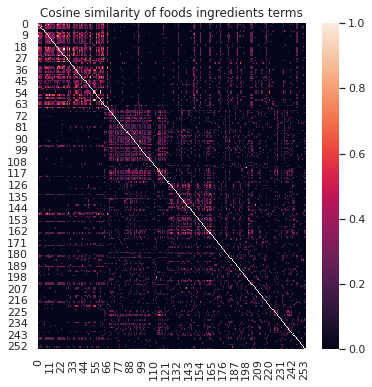

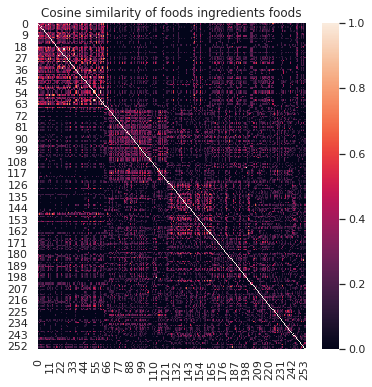

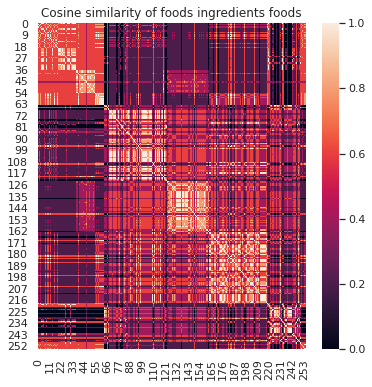

In [253]:
plt.figure(figsize=(6, 6))
ax = sns.heatmap(term_sim_mat)
ax.set_title("Cosine similarity of foods ingredients terms")

plt.figure(figsize=(6, 6))
ax = sns.heatmap(word_sim_mat)
ax.set_title("Cosine similarity of foods ingredients foods")

plt.figure(figsize=(6, 6))
ax = sns.heatmap(misc_sim_mat)
ax.set_title("Cosine similarity of foods ingredients foods")

### Recommendation function body 

This function recommends a food from the indian food dataset based on similarity to another dish defined as "dish_name" parameter. The similarities are measured acording to similarity score which is the weighted sum of cosine similarity of food ingredient terms, food ingredient words, foods additional data (origin). Due to the fact that the food additional data are very much alike, the have been down weighted for measuting similarities and technically they have been used as tie breakers for cases where multiple foods are highly similar with input. The weights are as follow:

* Food ingredient terms --> 0.48
* food ingredient words --> 0.47
* foods additional data --> 0.05

These weights are selected based on try and error. I have tuned the model by running the model several times and adjusting the weights to get the best results.  

Also, as discussed for filter function, the similar food data frame can be filtered based on 4 criteria of diet type, course, maximum preparation, and cooking time. Parameters are not case sensitive.

* param dish_name: The dish name against which similarities of other dishes are measured
* param diet: The diet to be 'vegetarian' or 'non vegetarian'
* param course: The course for which the dish should be served can be 'dessert', 'main course', 'starter', 'snack'
* param max_prep_time: The maximum preparation rime
* param max_cook_time: The maximum cooking time

---
Below examples are all correct application of function: <br>
* recommend_similar_dish(dish_name='Bora Sawul', max_prep_time=100, max_cook_time=100, diet='non vegetarian')
* recommend_similar_dish(dish_name='Goja', max_prep_time=100, max_cook_time=100, diet='vegetarian', course='snack')
* recommend_similar_dish(dish_name='Shukto')

In [254]:
term_w = 0.48
word_w = 0.47
data_w = 0.05

def recommend_similar_dish(dish_name, diet=None, max_prep_time=None, max_cook_time=None, course=None):
    """
    Recommend a food from the indian food dataset based on similarity to the dish_name parameter.
    The similarities are measured using cosine similarity method based on three criterias of food ingredient terms,
    food ingredient words, foods additional data (origin). The foods are them sorted from most similar to least
    similar. Similar foods data frame can be filtered based on 4 criteria of diet type, course, maximum preparation
    and cooking time.

    At fist all input are checked to be of the right format and within the acceptable values. This process is not
    100% error proof but can prevent elementary input errors. Below examples are all correct application of function.
    recommend_similar_dish(dish_name='Bora Sawul', max_prep_time=100, max_cook_time=100, diet='non vegetarian')
    recommend_similar_dish(dish_name='Goja', max_prep_time=100, max_cook_time=100, diet='vegetarian', course='snack')
    recommend_similar_dish(dish_name='Shukto')

    :param dish_name: The dish name against which similarities of other dishes are measured
    :param diet: The diet to be 'vegetarian' or 'non vegetarian'
    :param course: The course for which the dish should be served can be 'dessert', 'main course', 'starter', 'snack'
    :param max_prep_time: The maximum preparation rime
    :param max_cook_time: The maximum cooking time
    :return: Sorted dish data frame
    """
    global data_print
    global term_sim_df
    global word_sim_df
    global misc_sim_df
    if dish_name is None or str(dish_name).lower() not in set(term_sim_df.columns):
        print('Provided dish name "%s" is not available in Indian DIsh Dataset. Please try again.' % dish_name)
    dish_name = dish_name.lower()
    data_sorted = pd.concat([data_print, term_sim_df[dish_name]], axis=1)
    data_sorted.rename(columns={dish_name: 'term score'}, inplace=True)

    data_sorted = pd.concat([data_sorted, word_sim_df[dish_name]], axis=1)
    data_sorted.rename(columns={dish_name: 'word score'}, inplace=True)

    data_sorted = pd.concat([data_sorted, misc_sim_df[dish_name]], axis=1)
    data_sorted.rename(columns={dish_name: 'misc score'}, inplace=True)

    # Generating the total similarity score based on which dish data frame is sorted
    data_sorted['similarity score'] = term_w * data_sorted['term score'] + word_w * data_sorted['word score'] + data_w * data_sorted['misc score']
    data_sorted.sort_values(by='similarity score', ascending=False, inplace=True)

    # Filtering based on diet
    if diet is not None:
        diet = diet.lower()
        if diet not in data_2['diet'].unique():
            print('Diet option input "%s" not valid. You may choose from: %s' % (diet, data_2['diet'].unique()))
            return
        else:
            print('Filtering similar dishes based on diet type of %s.' % diet)
            data_sorted = data_sorted[data_2['diet'] == diet.lower()]

    # Filtering based on course
    if course is not None:
        course = course.lower()
        if course not in data_2['course'].unique():
            print('Course option input "%s" not valid. You may choose from: %s' % (course, data_2['course'].unique()))
            return
        else:
            print('Filtering similar dishes based on course type of %s.' % course)
            data_sorted = data_sorted[data_2['course'] == course.lower()]

    # Filtering based on maximum preparation time
    if max_prep_time is not None:
        try:
            max_prep_time = int(max_prep_time)
            print('Filtering similar dishes with maximum preparation time of %d.' % max_prep_time)
            data_sorted = data_sorted[(data_2['prep_time'] <= max_prep_time)]
        except ValueError:
            print('Incorrect input for prep time (%s)' % max_prep_time)
            return

    # Filtering based on maximum cooking time
    if max_cook_time is not None:
        try:
            max_cook_time = int(max_cook_time)
            print('Filtering similar dishes with maximum cooking time of %d.' % max_cook_time)
            data_sorted = data_sorted[(data_2['cook_time'] <= max_cook_time)]
        except ValueError:
            print('Incorrect input for cook time (%s)' % max_cook_time)
            return

    print('_' * 80)
    if len(data_sorted) == 0:
        print('There are no similar dishes under mentioned criteria')
    else:
        print('Here are similar dishes to "%s" arranged from more similar to least similar' % dish_name)
        # data_res = pd.concat([data_print.loc[data_sorted.index], data_sorted['similarity score']], axis=1)
        display(data_sorted.head())
        return data_sorted

In [255]:
recommend_similar_dish(dish_name='sohan papdi')
print('')

________________________________________________________________________________
Here are similar dishes to "sohan papdi" arranged from more similar to least similar


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,term score,word score,misc score,similarity score
19,Sohan Papdi,"Gram Flour, Ghee, Sugar, Milk, Cardamom",Vegetarian,35.0*,60.0,Sweet,Dessert,Maharashtra,West,1.000000,1.000000,1.0,1.000000
1,Boondi,"Gram Flour, Ghee, Sugar",Vegetarian,80.0,30.0,Sweet,Dessert,Rajasthan,West,0.774597,0.816497,0.8,0.795560
10,Laddu,"Gram Flour, Ghee, Sugar",Vegetarian,10.0,40.0,Sweet,Dessert,Gujarat*,West*,0.774597,0.816497,0.8,0.795560
7,Kaju Katli,"Cashews, Ghee, Cardamom, Sugar",Vegetarian,10.0,20.0,Sweet,Dessert,Gujarat*,West*,0.670820,0.612372,0.8,0.649809
66,Chak Hao Kheer,"Rice, Milk, Sugar, Cardamom",Vegetarian,240.0,45.0,Sweet,Dessert,Manipur,North East,0.670820,0.612372,0.6,0.639809


In [256]:
recommend_similar_dish(dish_name='Kaju Katli')
print('')

________________________________________________________________________________
Here are similar dishes to "kaju katli" arranged from more similar to least similar


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,term score,word score,misc score,similarity score
7,Kaju Katli,"Cashews, Ghee, Cardamom, Sugar",Vegetarian,10.0,20.0,Sweet,Dessert,Gujarat*,West*,1.000000,1.000000,1.0,1.000000
19,Sohan Papdi,"Gram Flour, Ghee, Sugar, Milk, Cardamom",Vegetarian,35.0*,60.0,Sweet,Dessert,Maharashtra,West,0.670820,0.612372,0.8,0.649809
2,Gajar Ka Halwa,"Carrots, Milk, Sugar, Ghee, Cashews, Raisins",Vegetarian,15.0,60.0,Sweet,Dessert,Punjab,North,0.612372,0.612372,0.6,0.611754
25,Ledikeni,"Chhena, Sugar, Ghee",Vegetarian,45.0,45.0,Sweet,Dessert,West Bengal,East,0.577350,0.577350,0.6,0.578483
20,Chhena Jalebi,"Chhena, Sugar, Ghee",Vegetarian,10.0,50.0,Sweet,Dessert,Odisha,East,0.577350,0.577350,0.6,0.578483


## Recommendation System for Gluten Free Dishes
To develop a recommendation system for Gluten-free dishes, same methodology as previous recommendation is used with a difference that 
* Firstly, all non-Gluten-free ingredients are removed from ingredient list of each dish.
* Using the new recepies and following methodology from previous section, the simillarities between foods are calculated. 
* Original dataset is ordered according to calculated similarity scores.
* The foods with non-Gluten-ingredients are removed from sorted dataset and is shown. 

By following above steps, 
1. Similarities are analysed only considering the Gluten-free ingredients.
2. Original dataset with untouched recepies are sorted based on Gluten-free similarity scores.
3. **Non-Gluten-free foods are not suggested but can be used for recommending. Meaning, the user can find the Gluten-free food most similar to a Non-Gluten-free food.**

Since it is already explained, the methodology for finding similarity scores is not further explained. A list of ingredients with Gluten is obtained from  [WebMD](https://www.webmd.com/diet/features/hidden-sources-of-gluten#1). Any food containing following ingredients is removed from database.

In [257]:
data_term_gf = data_2.copy()
gluten_ing = ['wheat', 'gram-flour', 'barley', 'yeast', 'bulgur', 'durum', 'kamut', 'malt', 'matzo', 'oat', 'rye', 'semolina', 'gram flour']
indexes_to_drop = []
for i, row in data_term_gf.iterrows():
    for g_ing in gluten_ing:
        if g_ing in row['ingredients']:
            indexes_to_drop.append(i)
            break

In [258]:
data_term_gf['ingredients'] = data_term_gf['ingredients'].apply(lambda x: [w.strip() for w in x.split(',')])
data_term_gf['ingredients'] = data_term_gf['ingredients'].apply(lambda x: [term.replace(' ', '-') for term in x])
for g_ing in gluten_ing:
    data_term_gf['ingredients'] = data_term_gf['ingredients'].apply(lambda row: [x for x in row if g_ing not in x])

term_remove_list = ['water', 'salt', 'pepper', 'sweet']
data_term_gf['ingredients'] = data_term_gf['ingredients'].apply(lambda row: [x for x in row if x not in term_remove_list])

term_replace_dic = {'maida': 'maida-flour', 'powdered-sugar': 'sugar', 'whole-egg': 'egg'}
for i, row in data_term_gf.iterrows():
    for ing, ing_correct in term_replace_dic.items():
        if ing in row['ingredients']:
            row['ingredients'].remove(ing)
            row['ingredients'].append(ing_correct)

word_replace_dic = {'-and': '', 'frozen-': '', 'canned-': '', '-powder': ''}
for k, v in word_replace_dic.items():
    data_term_gf['ingredients'] = data_term_gf['ingredients'].apply(lambda row: [x.replace(k, v) for x in row])

# Stemming the ingredient terms
data_term_gf['ingredients'] = data_term_gf['ingredients'].apply(lambda row: [ps.stem(x) for x in row])

data_word_gf = data_term_gf.copy()
data_word_gf['ingredients'] = data_word_gf['ingredients'].apply(lambda x: list(sum([s.split('-') for s in x], [])))

# Generating the ingredient bag of the TERMS and WORDS vectorizing in a one-hot fashion
term_one_hot_gf = vectorize_ingred(data_term_gf)
word_one_hot_gf = vectorize_ingred(data_word_gf)

# Similarity matrices based on terms, words and additional data using Cosine-similarity methods
term_sim_mat_gf = cosine_similarity(np.array(term_one_hot_gf))
term_sim_df_gf = pd.DataFrame(data=term_sim_mat_gf, index=data_term_gf.index, columns=data_term_gf['name'])

word_sim_mat_gf = cosine_similarity(np.array(word_one_hot_gf))
word_sim_df_gf = pd.DataFrame(data=word_sim_mat_gf, index=data_word_gf.index, columns=data_word_gf['name'])

misc_sim_df_gf = misc_sim_df.copy()

In [259]:
term_w_gf = 0.48
word_w_gf = 0.47
data_w_gf = 0.05

def recommend_similar_dish_gluten_free(dish_name, diet=None, max_prep_time=None, max_cook_time=None, course=None):
    """
    Recommend a Gluten-free food from the indian food dataset based on similarity to the dish_name parameter.
    The similarities are measured using cosine similarity method based on three criterias of food ingredient terms,
    food ingredient words, foods additional data (origin). The foods are them sorted from most similar to least
    similar. Similar foods data frame can be filtered based on 4 criteria of diet type, course, maximum preparation
    and cooking time.

    At fist all input are checked to be of the right format and within the acceptable values. This process is not
    100% error proof but can prevent elementary input errors. Below examples are all correct application of function.
    recommend_similar_dish(dish_name='Bora Sawul', max_prep_time=100, max_cook_time=100, diet='non vegetarian')
    recommend_similar_dish(dish_name='Goja', max_prep_time=100, max_cook_time=100, diet='vegetarian', course='snack')
    recommend_similar_dish(dish_name='Shukto')

    :param dish_name: The dish name against which similarities of other dishes are measured
    :param diet: The diet to be 'vegetarian' or 'non vegetarian'
    :param course: The course for which the dish should be served can be 'dessert', 'main course', 'starter', 'snack'
    :param max_prep_time: The maximum preparation rime
    :param max_cook_time: The maximum cooking time
    :return: Sorted dish data frame
    """
    global data_print
    global term_sim_df_gf
    global word_sim_df_gf
    global misc_sim_df_gf
    if dish_name is None or str(dish_name).lower() not in set(term_sim_df_gf.columns):
        print('Provided dish name "%s" is not available in Indian Dish Dataset. Please try again.' % dish_name)
    dish_name = dish_name.lower()
    data_sorted = pd.concat([data_print, term_sim_df_gf[dish_name]], axis=1)
    data_sorted.rename(columns={dish_name: 'term score'}, inplace=True)

    data_sorted = pd.concat([data_sorted, word_sim_df_gf[dish_name]], axis=1)
    data_sorted.rename(columns={dish_name: 'word score'}, inplace=True)

    data_sorted = pd.concat([data_sorted, misc_sim_df_gf[dish_name]], axis=1)
    data_sorted.rename(columns={dish_name: 'misc score'}, inplace=True)

    # Generating the total similarity score based on which dish data frame is sorted
    data_sorted['similarity score'] = term_w_gf * data_sorted['term score'] + word_w_gf * data_sorted[
        'word score'] + data_w_gf * data_sorted['misc score']
    data_sorted.sort_values(by='similarity score', ascending=False, inplace=True)

    # Filtering based on diet
    if diet is not None:
        if diet.lower() not in data_term_gf['diet'].unique():
            print('Diet option input "%s" not valid. You may choose from: %s' % (diet, data_2_gf['diet'].unique()))
            return
        else:
            print('Filtering similar dishes based on diet type of %s.' % diet)
            data_sorted = data_sorted[data_term_gf['diet'] == diet.lower()]

    # Filtering based on course
    if course is not None:
        if course.lower() not in data_term_gf['course'].unique():
            print(
                'Course option input "%s" not valid. You may choose from: %s' % (course, data_2_gf['course'].unique()))
            return
        else:
            print('Filtering similar dishes based on course type of %s.' % course)
            data_sorted = data_sorted[data_term_gf['course'] == course.lower()]

    # Filtering based on maximum preparation time
    if max_prep_time is not None:
        try:
            max_prep_time = int(max_prep_time)
            print('Filtering similar dishes with maximum preparation time of %d.' % max_prep_time)
            data_sorted = data_sorted[(data_term_gf['prep_time'] <= max_prep_time)]
        except ValueError:
            print('Incorrect input for prep time (%s)' % max_prep_time)
            return

    # Filtering based on maximum cooking time
    if max_cook_time is not None:
        try:
            max_cook_time = int(max_cook_time)
            print('Filtering similar dishes with maximum cooking time of %d.' % max_cook_time)
            data_sorted = data_sorted[(data_term_gf['cook_time'] <= max_cook_time)]
        except ValueError:
            print('Incorrect input for cook time (%s)' % max_cook_time)
            return

    print('_' * 80)
    if len(data_sorted) == 0:
        print('There are no similar dishes under mentioned criteria')
    else:
        data_sorted.drop(indexes_to_drop, inplace=True)
        print('Here are similar dishes to "%s" arranged from more similar to least similar' % dish_name)
        # data_res = pd.concat([data_print.loc[data_sorted.index], data_sorted['similarity score']], axis=1)
        display(data_sorted.head())
        return data_sorted

In [260]:
print('Regular recommendation')
recommend_similar_dish(dish_name='Kaju Katli')
print('\n' + '-' * 90)
print('Gluten-free recommendation')
recommend_similar_dish_gluten_free(dish_name='Kaju Katli')
print('')

Regular recommendation
________________________________________________________________________________
Here are similar dishes to "kaju katli" arranged from more similar to least similar


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,term score,word score,misc score,similarity score
7,Kaju Katli,"Cashews, Ghee, Cardamom, Sugar",Vegetarian,10.0,20.0,Sweet,Dessert,Gujarat*,West*,1.000000,1.000000,1.0,1.000000
19,Sohan Papdi,"Gram Flour, Ghee, Sugar, Milk, Cardamom",Vegetarian,35.0*,60.0,Sweet,Dessert,Maharashtra,West,0.670820,0.612372,0.8,0.649809
2,Gajar Ka Halwa,"Carrots, Milk, Sugar, Ghee, Cashews, Raisins",Vegetarian,15.0,60.0,Sweet,Dessert,Punjab,North,0.612372,0.612372,0.6,0.611754
25,Ledikeni,"Chhena, Sugar, Ghee",Vegetarian,45.0,45.0,Sweet,Dessert,West Bengal,East,0.577350,0.577350,0.6,0.578483
20,Chhena Jalebi,"Chhena, Sugar, Ghee",Vegetarian,10.0,50.0,Sweet,Dessert,Odisha,East,0.577350,0.577350,0.6,0.578483



------------------------------------------------------------------------------------------
Gluten-free recommendation
________________________________________________________________________________
Here are similar dishes to "kaju katli" arranged from more similar to least similar


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,term score,word score,misc score,similarity score
7,Kaju Katli,"Cashews, Ghee, Cardamom, Sugar",Vegetarian,10.0,20.0,Sweet,Dessert,Gujarat*,West*,1.000000,1.000000,1.0,1.000000
2,Gajar Ka Halwa,"Carrots, Milk, Sugar, Ghee, Cashews, Raisins",Vegetarian,15.0,60.0,Sweet,Dessert,Punjab,North,0.612372,0.612372,0.6,0.611754
20,Chhena Jalebi,"Chhena, Sugar, Ghee",Vegetarian,10.0,50.0,Sweet,Dessert,Odisha,East,0.577350,0.577350,0.6,0.578483
25,Ledikeni,"Chhena, Sugar, Ghee",Vegetarian,45.0,45.0,Sweet,Dessert,West Bengal,East,0.577350,0.577350,0.6,0.578483
34,Rasgulla,"Chhena, Sugar, Cardamom",Vegetarian,10.0,90.0,Sweet,Dessert,West Bengal,East,0.577350,0.577350,0.6,0.578483


In [261]:
print('Regular recommendation')
recommend_similar_dish(dish_name='Sohan Papdi')
print('\n' + '-' * 90)
print('Gluten-free recommendation')
recommend_similar_dish_gluten_free(dish_name='Sohan Papdi')
print('')

Regular recommendation
________________________________________________________________________________
Here are similar dishes to "sohan papdi" arranged from more similar to least similar


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,term score,word score,misc score,similarity score
19,Sohan Papdi,"Gram Flour, Ghee, Sugar, Milk, Cardamom",Vegetarian,35.0*,60.0,Sweet,Dessert,Maharashtra,West,1.000000,1.000000,1.0,1.000000
1,Boondi,"Gram Flour, Ghee, Sugar",Vegetarian,80.0,30.0,Sweet,Dessert,Rajasthan,West,0.774597,0.816497,0.8,0.795560
10,Laddu,"Gram Flour, Ghee, Sugar",Vegetarian,10.0,40.0,Sweet,Dessert,Gujarat*,West*,0.774597,0.816497,0.8,0.795560
7,Kaju Katli,"Cashews, Ghee, Cardamom, Sugar",Vegetarian,10.0,20.0,Sweet,Dessert,Gujarat*,West*,0.670820,0.612372,0.8,0.649809
66,Chak Hao Kheer,"Rice, Milk, Sugar, Cardamom",Vegetarian,240.0,45.0,Sweet,Dessert,Manipur,North East,0.670820,0.612372,0.6,0.639809



------------------------------------------------------------------------------------------
Gluten-free recommendation
________________________________________________________________________________
Here are similar dishes to "sohan papdi" arranged from more similar to least similar


,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,term score,word score,misc score,similarity score
7,Kaju Katli,"Cashews, Ghee, Cardamom, Sugar",Vegetarian,10.0,20.0,Sweet,Dessert,Gujarat*,West*,0.750000,0.750000,0.8,0.752500
35,Sandesh,"Milk, Sugar, Saffron, Cardamom",Vegetarian,30.0,20.0,Sweet,Dessert,West Bengal,East,0.750000,0.750000,0.6,0.742500
66,Chak Hao Kheer,"Rice, Milk, Sugar, Cardamom",Vegetarian,240.0,45.0,Sweet,Dessert,Manipur,North East,0.750000,0.750000,0.6,0.742500
2,Gajar Ka Halwa,"Carrots, Milk, Sugar, Ghee, Cashews, Raisins",Vegetarian,15.0,60.0,Sweet,Dessert,Punjab,North,0.612372,0.612372,0.6,0.611754
56,Basundi,"Sugar, Milk, Nuts",Vegetarian,10.0,35.0,Sweet,Dessert,Gujarat,West,0.577350,0.577350,0.8,0.588483
